In [1]:
# TensorFlow / Keras for Deep Learning
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Machine Learning & Data Processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from langdetect import detect, DetectorFactory

# Regular Expressions & String Processing
import re
import string

# Data Visualization
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tswr1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tswr1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tswr1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [2]:
spotify_reviews= pd.read_csv('./spotify_reviews.csv')

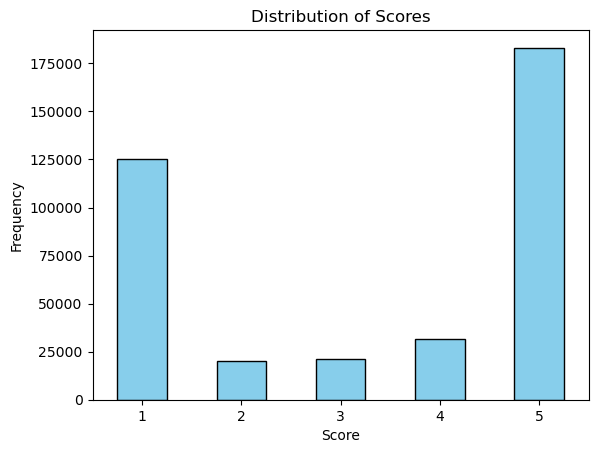

In [3]:
spotify_reviews['score'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.xticks(rotation=0)
plt.show()

In [4]:
print("Class distribution:", spotify_reviews['score'].value_counts())

Class distribution: score
5    183128
1    125258
4     31441
3     21102
2     20071
Name: count, dtype: int64


### 1.2 Data Processing

In [5]:
spotify_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381000 entries, 0 to 380999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              381000 non-null  object
 1   userName              380997 non-null  object
 2   userImage             381000 non-null  object
 3   content               380989 non-null  object
 4   score                 381000 non-null  int64 
 5   thumbsUpCount         381000 non-null  int64 
 6   reviewCreatedVersion  299182 non-null  object
 7   at                    381000 non-null  object
 8   replyContent          34000 non-null   object
 9   repliedAt             34000 non-null   object
 10  appVersion            299182 non-null  object
dtypes: int64(2), object(9)
memory usage: 32.0+ MB


### Dropping useless columns

In [6]:
spotify_reviews.drop(columns=['reviewId','userName','userImage','reviewCreatedVersion','replyContent','repliedAt','appVersion','at','thumbsUpCount'], inplace=True)

In [7]:
spotify_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381000 entries, 0 to 380999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  380989 non-null  object
 1   score    381000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ MB


In [8]:
spotify_reviews = spotify_reviews[spotify_reviews['content'].notnull()]

### Undersampling

In [9]:
X = spotify_reviews.drop(columns=['score'])  # Drop 'score' from input features
y = spotify_reviews['score']  # Target variable

# Define the sampling strategy to get exactly 20,000 per class
desired_samples = 20000  
sampling_strategy = {label: desired_samples for label in y.unique()}  # Explicit strategy

# Apply undersampling with the correct strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Recombine into a new DataFrame
spotify_reviews_resampled = pd.DataFrame(X_resampled, columns=X.columns)
spotify_reviews_resampled['score'] = y_resampled  # Add back target column

# Print new class distribution
print("Class distribution after undersampling:", spotify_reviews_resampled['score'].value_counts())
spotify_reviews = spotify_reviews_resampled

Class distribution after undersampling: score
1    20000
2    20000
3    20000
4    20000
5    20000
Name: count, dtype: int64


In [10]:
spotify_reviews.shape

(100000, 2)

### 1. Lower Casing

In [11]:
spotify_reviews.tail(100)

,content,score
117651,sooooo good,5
323632,Fast to searching song,5
248006,Love spotify beacause Im A music addict lol,5
17678,❤️❤️❤️,5
187951,Excellent,5
...,...,...
132762,My favorite app for years,5
340212,Can't live without. Don't have to drag CDs eve...,5
251849,Love the music,5
283925,Un imprescindible para nosotros,5


In [12]:
spotify_reviews['content'] = spotify_reviews['content'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [13]:
spotify_reviews.tail(100)

,content,score
117651,sooooo good,5
323632,fast to searching song,5
248006,love spotify beacause im a music addict lol,5
17678,❤️❤️❤️,5
187951,excellent,5
...,...,...
132762,my favorite app for years,5
340212,can't live without. don't have to drag cds eve...,5
251849,love the music,5
283925,un imprescindible para nosotros,5


### 2. Expanding Contractions

In [14]:
spotify_reviews.tail(100)

,content,score
117651,sooooo good,5
323632,fast to searching song,5
248006,love spotify beacause im a music addict lol,5
17678,❤️❤️❤️,5
187951,excellent,5
...,...,...
132762,my favorite app for years,5
340212,can't live without. don't have to drag cds eve...,5
251849,love the music,5
283925,un imprescindible para nosotros,5


In [15]:
contractions_dict = {
    "ain't": "are not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am","it's":"it is",
    "i've": "i have", "isn't": "is not", "let's": "let us", "mightn't": "might not",
    "mustn't": "must not", "shan't": "shall not", "she'd": "she would", "she'll": "she will",
    "she's": "she is", "shouldn't": "should not", "that's": "that is", "there's": "there is",
    "they'd": "they would", "they'll": "they will", "they're": "they are", "they've": "they have",
    "we'd": "we would", "we're": "we are", "weren't": "were not", "we've": "we have",
    "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have",
    "where's": "where is", "who'd": "who would", "who'll": "who will", "who're": "who are",
    "who's": "who is", "who've": "who have", "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have"
}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
spotify_reviews['content']=spotify_reviews['content'].apply(lambda x:expand_contractions(x))

In [16]:
spotify_reviews.tail(100)

,content,score
117651,sooooo good,5
323632,fast to searching song,5
248006,love spotify beacause im a music addict lol,5
17678,❤️❤️❤️,5
187951,excellent,5
...,...,...
132762,my favorite app for years,5
340212,cannot live without. do not have to drag cds e...,5
251849,love the music,5
283925,un imprescindible para nosotros,5


### 3. Removing Punctuations

In [17]:
spotify_reviews['content'] = spotify_reviews['content'].apply(
    lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)
)

In [18]:
spotify_reviews.tail(100)

,content,score
117651,sooooo good,5
323632,fast to searching song,5
248006,love spotify beacause im a music addict lol,5
17678,❤️❤️❤️,5
187951,excellent,5
...,...,...
132762,my favorite app for years,5
340212,cannot live without do not have to drag cds ev...,5
251849,love the music,5
283925,un imprescindible para nosotros,5


### 4. Removing digits (standalone digits)

In [19]:
spotify_reviews.head(20)

,content,score
367033,very bad move the free version now makes no se...,1
186206,you need premium account just for rewind wild,1
17029,why would i want to go to a billie concert ple...,1
202197,you have to have premium to pick what songs yo...,1
292703,very bad new restrictions are worse every song...,1
368219,this used to be the best app for listening mus...,1
327593,worst situation ever everything is running on ...,1
135751,too much ads always wants us to be put into pr...,1
32597,your spotify wrapped sucks this year and your ...,1
12797,1 star cause i cannot off shuffle mode,1


In [20]:
spotify_reviews['content'] = spotify_reviews['content'].apply(lambda text: re.sub(r'\b\d+\b', '', text))

In [21]:
spotify_reviews.head(20)

,content,score
367033,very bad move the free version now makes no se...,1
186206,you need premium account just for rewind wild,1
17029,why would i want to go to a billie concert ple...,1
202197,you have to have premium to pick what songs yo...,1
292703,very bad new restrictions are worse every song...,1
368219,this used to be the best app for listening mus...,1
327593,worst situation ever everything is running on ...,1
135751,too much ads always wants us to be put into pr...,1
32597,your spotify wrapped sucks this year and your ...,1
12797,star cause i cannot off shuffle mode,1


### 5. Removing Emojis

mobilelegends_reviews.head(50) 

In [22]:
def remove_emojis(data):
    """Removes emojis and special symbols"""
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # Dingbats
        u"\u3030"
        "]+", re.UNICODE)
    return re.sub(emoj, '', data)
spotify_reviews['content'] = spotify_reviews['content'].apply(remove_emojis)

In [23]:
spotify_reviews.head(50) 

,content,score
367033,very bad move the free version now makes no se...,1
186206,you need premium account just for rewind wild,1
17029,why would i want to go to a billie concert ple...,1
202197,you have to have premium to pick what songs yo...,1
292703,very bad new restrictions are worse every song...,1
368219,this used to be the best app for listening mus...,1
327593,worst situation ever everything is running on ...,1
135751,too much ads always wants us to be put into pr...,1
32597,your spotify wrapped sucks this year and your ...,1
12797,star cause i cannot off shuffle mode,1


### 6. Removing Stopwords

In [24]:
spotify_reviews.head(20)

,content,score
367033,very bad move the free version now makes no se...,1
186206,you need premium account just for rewind wild,1
17029,why would i want to go to a billie concert ple...,1
202197,you have to have premium to pick what songs yo...,1
292703,very bad new restrictions are worse every song...,1
368219,this used to be the best app for listening mus...,1
327593,worst situation ever everything is running on ...,1
135751,too much ads always wants us to be put into pr...,1
32597,your spotify wrapped sucks this year and your ...,1
12797,star cause i cannot off shuffle mode,1


In [25]:
stop_words = stopwords.words('english')
def remove_stopwords(text):
    """Removes stopwords from already lowercased text."""
    return " ".join([word for word in text.split() if word not in stop_words])
spotify_reviews['content'] = spotify_reviews['content'].apply(remove_stopwords)

In [26]:
spotify_reviews.head(20)

,content,score
367033,bad move free version makes sense extremely im...,1
186206,need premium account rewind wild,1
17029,would want go billie concert please remove ads...,1
202197,premium pick songs want listen order everythin...,1
292703,bad new restrictions worse every song day bad ...,1
368219,used best app listening music premium restrict...,1
327593,worst situation ever everything running premiu...,1
135751,much ads always wants us put premium eventho b...,1
32597,spotify wrapped sucks year data sus giving app...,1
12797,star cause cannot shuffle mode,1


### 7. Lemmatisation

In [27]:
spotify_reviews.head(30)

,content,score
367033,bad move free version makes sense extremely im...,1
186206,need premium account rewind wild,1
17029,would want go billie concert please remove ads...,1
202197,premium pick songs want listen order everythin...,1
292703,bad new restrictions worse every song day bad ...,1
368219,used best app listening music premium restrict...,1
327593,worst situation ever everything running premiu...,1
135751,much ads always wants us put premium eventho b...,1
32597,spotify wrapped sucks year data sus giving app...,1
12797,star cause cannot shuffle mode,1


In [28]:
import nltk
nltk.data.find('taggers/averaged_perceptron_tagger')

FileSystemPathPointer('C:\\Users\\tswr1\\AppData\\Roaming\\nltk_data\\taggers\\averaged_perceptron_tagger')

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tswr1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
nltk.download('averaged_perceptron_tagger_eng')  # For English

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\tswr1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [31]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK POS tags to WordNet POS format
def get_wordnet_pos(word, tag):
    """Convert POS tag from NLTK to WordNet format."""
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN if not found

# Improved lemmatization function with full POS tagging
def lemmatize_words(text):
    """Lemmatizes words using correct POS tagging."""
    if not isinstance(text, str):  # Handle missing values
        return ""
    words = word_tokenize(text)  # Tokenize text into words
    tagged_words = pos_tag(words)  # Apply POS tagging to all words
    return " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word, tag[0].upper())) for word, tag in tagged_words])

spotify_reviews['content'] = spotify_reviews['content'].apply(lemmatize_words)

In [32]:
text = "many bug reconnecting"
words = word_tokenize(text)
tagged_words = pos_tag(words)

print(tagged_words)  # Check POS tagging

[('many', 'JJ'), ('bug', 'NN'), ('reconnecting', 'VBG')]


In [33]:
print(lemmatizer.lemmatize("running", pos=wordnet.VERB))  # Should output "run"
print(lemmatizer.lemmatize("jumping", pos=wordnet.VERB))  # Should output "jump"

run
jump


In [34]:
print(lemmatizer.lemmatize("reconnecting", pos=wordnet.VERB))

reconnecting


In [35]:
spotify_reviews.head(30)

,content,score
367033,bad move free version make sense extremely imp...,1
186206,need premium account rewind wild,1
17029,would want go billie concert please remove ad ...,1
202197,premium pick song want listen order everything...,1
292703,bad new restriction bad every song day bad pol...,1
368219,use best app listen music premium restriction ...,1
327593,bad situation ever everything run premium lite...,1
135751,much ad always want u put premium eventho brea...,1
32597,spotify wrap suck year data sus give app star,1
12797,star cause can not shuffle mode,1


### 8. Removing Extra Whitespaces

In [36]:
spotify_reviews['content'] = spotify_reviews['content'].apply(lambda text: re.sub(' +', ' ', text).strip())

In [37]:
spotify_reviews.to_csv('spotify_reviews_cleaned.csv', index=False)

### 1.3 Data Sampling

In [38]:
spotify_reviews.shape

(100000, 2)

### Undersampling the data

In [39]:
# Shift labels from [1, 2, 3, 4, 5] → [0, 1, 2, 3, 4]
spotify_reviews['score'] = spotify_reviews['score'] - 1

# Split the X & y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    spotify_reviews.drop(columns=['score']),  # Drop 'score' from input features
    spotify_reviews['score'], 
    test_size=0.2, 
    random_state=0,
    stratify = spotify_reviews['score']
)

In [40]:
X_train.shape

(80000, 1)

In [41]:
X_test.shape

(20000, 1)

In [42]:
y_test.shape

(20000,)

In [43]:
y_train.shape

(80000,)

In [44]:
max_features = 10000  # Number of unique words to keep
maxlen = 100          # Max length of each sequence (padding/truncating)

# Initialize and fit the tokenizer with OOV token
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")  # 🚀 Handle unknown words
tokenizer.fit_on_texts(X_train['content'])  # Learn word-to-index mapping from the training set

# Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train['content'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['content'])

# Pad sequences to ensure uniform length
X_train = preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=maxlen, truncating='post')
X_test = preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=maxlen, truncating='post')

# Check OOV token index
print(tokenizer.word_index["<OOV>"])  # 🚀 Prints the index assigned to OOV words

1


In [45]:
word_index = tokenizer.word_index
print(word_index)  # Print the word-to-index dictionary

{'<OOV>': 1, 'app': 2, 'song': 3, 'music': 4, 'spotify': 5, 'premium': 6, 'play': 7, 'good': 8, 'ad': 9, 'listen': 10, 'like': 11, 'get': 12, 'use': 13, 'can': 14, 'not': 15, 'playlist': 16, 'even': 17, 'bad': 18, 'want': 19, 'love': 20, 'time': 21, 'add': 22, 'pay': 23, 'lyric': 24, 'make': 25, 'great': 26, 'update': 27, 'one': 28, 'free': 29, 'shuffle': 30, 'go': 31, 'work': 32, 'every': 33, 'best': 34, 'many': 35, 'please': 36, 'really': 37, 'would': 38, 'need': 39, 'fix': 40, 'give': 41, 'much': 42, 'feature': 43, 'skip': 44, 'new': 45, 'nice': 46, 'u': 47, 'also': 48, 'stop': 49, 'download': 50, 'keep': 51, 'without': 52, 'thing': 53, 'well': 54, 'try': 55, 'annoy': 56, 'back': 57, 'still': 58, 'star': 59, 'change': 60, 'say': 61, 'experience': 62, 'problem': 63, 'user': 64, 'issue': 65, 'phone': 66, 'everything': 67, 'start': 68, 'money': 69, 'year': 70, 'see': 71, 'way': 72, 'option': 73, 'ever': 74, 'show': 75, 'day': 76, 'could': 77, 'find': 78, 'minute': 79, 'always': 80, 've

In [46]:
print(len(word_index))  # Total unique words in the vocabulary

35451


In [47]:
print(tokenizer.texts_to_sequences(["mike wee is a really good lecturer"]))  

[[8158, 8045, 1, 1, 37, 8, 1]]


In [150]:
X_test_df = pd.DataFrame(X_test)
X_test_df.to_csv("X_test_tricia.csv", index=False)

# Convert y_test to a DataFrame and export it
y_test_df = pd.DataFrame(y_test)  
y_test_df.to_csv("y_test_tricia.csv", index=False)

print("X_test and y_test have been saved as CSV files.")

X_test and y_test have been saved as CSV files.


## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

# My Models

### Model 1

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Build the simplified LSTM model
test4_model = Sequential()
test4_model.add(keras.Input(shape=(maxlen,)))
test4_model.add(Embedding(10000, 32))
test4_model.add(LSTM(16, dropout=0.3, recurrent_dropout=0.3))
test4_model.add(Dropout(0.5))  # Helps prevent overfitting
test4_model.add(Dense(5, activation='softmax'))
test4_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,221 (1.23 MB)

 Trainable params: 323,221 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
from tensorflow.keras.optimizers import RMSprop
test4_model.compile(optimizer = RMSprop(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']) 

history = test4_model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 99s 45ms/step - acc: 0.3039 - loss: 1.5216 - val_acc: 0.4345 - val_loss: 1.3159
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 106s 53ms/step - acc: 0.4168 - loss: 1.3334 - val_acc: 0.4564 - val_loss: 1.2507
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 123s 61ms/step - acc: 0.4453 - loss: 1.2851 - val_acc: 0.4658 - val_loss: 1.2318
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 116s 58ms/step - acc: 0.4546 - loss: 1.2679 - val_acc: 0.4713 - val_loss: 1.2199
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 128s 64ms/step - acc: 0.4616 - loss: 1.2584 - val_acc: 0.4753 - val_loss: 1.2119
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - acc: 0.4682 - loss: 1.2417 - val_acc: 0.4732 - val_loss: 1.2091
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 207s 84ms/step - acc: 0.4736 - loss: 1.2387 - val_acc: 0.4781 - val_loss: 1.2056
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 171s 85ms/step - acc: 0.4771 - loss: 1.2320 - val_acc: 0.4780 - val_loss: 1.2042
Epoch 9/15
2000/2

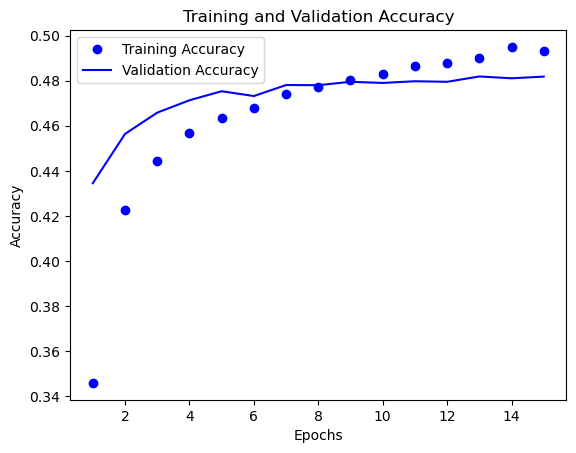

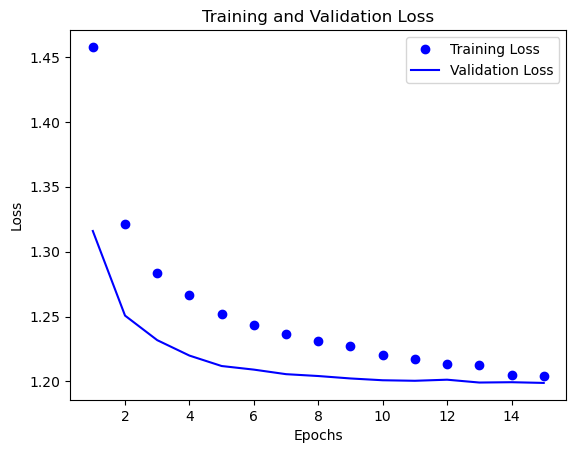

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
best_epoch = val_acc.index(max_val_acc) + 1 
print(f"Highest validation accuracy: {max_val_acc:.4f} at epoch {best_epoch}")

Highest validation accuracy: 0.4819 at epoch 13


In [ ]:
# Get model predictions
y_pred_probs = test4_model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step
Accuracy: 0.4813
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.56      0.58      4000
           1       0.42      0.44      0.43      4000
           2       0.37      0.30      0.33      4000
           3       0.44      0.30      0.35      4000
           4       0.53      0.80      0.64      4000

    accuracy                           0.48     20000
   macro avg       0.47      0.48      0.47     20000
weighted avg       0.47      0.48      0.47     20000



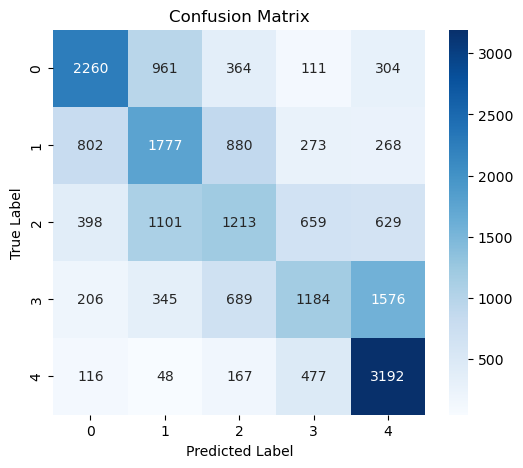

In [ ]:
import seaborn as sns
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test4_model.save('tricia_text_model_4.keras')

### Model 2

In [50]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Build the simplified LSTM model
test5_model = Sequential()
test5_model.add(keras.Input(shape=(maxlen,)))
test5_model.add(Embedding(10000, 32))
test5_model.add(LSTM(16, dropout=0.3, recurrent_dropout=0.3))
test5_model.add(Dropout(0.5))  # Helps prevent overfitting
test5_model.add(Dense(5, activation='softmax'))
test5_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,221 (1.23 MB)

 Trainable params: 323,221 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Train the Model
from tensorflow.keras.optimizers import RMSprop
test5_model.compile(optimizer = RMSprop(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']) 

history = test5_model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 90s 44ms/step - acc: 0.3192 - loss: 1.5211 - val_acc: 0.4341 - val_loss: 1.3093
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 93s 47ms/step - acc: 0.4235 - loss: 1.3315 - val_acc: 0.4591 - val_loss: 1.2434
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - acc: 0.4438 - loss: 1.2860 - val_acc: 0.4667 - val_loss: 1.2266
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - acc: 0.4566 - loss: 1.2697 - val_acc: 0.4703 - val_loss: 1.2170
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 89s 45ms/step - acc: 0.4621 - loss: 1.2530 - val_acc: 0.4734 - val_loss: 1.2102
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - acc: 0.4709 - loss: 1.2436 - val_acc: 0.4753 - val_loss: 1.2067
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - acc: 0.4747 - loss: 1.2328 - val_acc: 0.4770 - val_loss: 1.2055
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 91s 45ms/step - acc: 0.4810 - loss: 1.2241 - val_acc: 0.4794 - val_loss: 1.2046
Epoch 9/20
2000/2000 ━━━

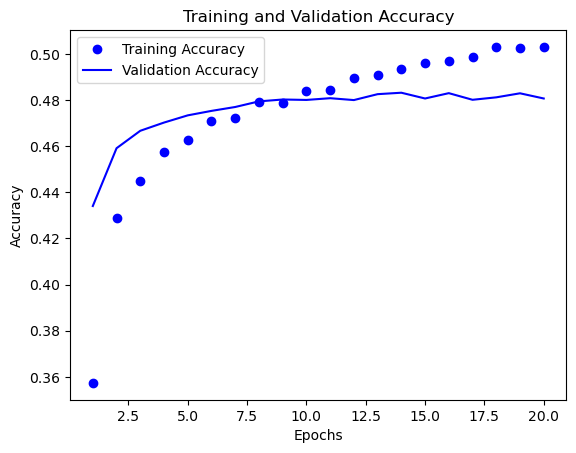

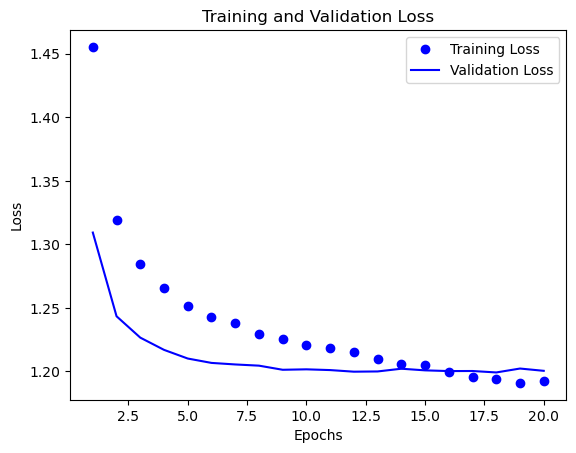

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
best_epoch = val_acc.index(max_val_acc) + 1 
print(f"Highest validation accuracy: {max_val_acc:.4f} at epoch {best_epoch}")

Highest validation accuracy: 0.4832 at epoch 14


In [55]:
# Get model predictions
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred_probs = test5_model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
Accuracy: 0.4817
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.58      4000
           1       0.41      0.50      0.45      4000
           2       0.37      0.26      0.31      4000
           3       0.45      0.28      0.34      4000
           4       0.53      0.81      0.64      4000

    accuracy                           0.48     20000
   macro avg       0.47      0.48      0.46     20000
weighted avg       0.47      0.48      0.46     20000



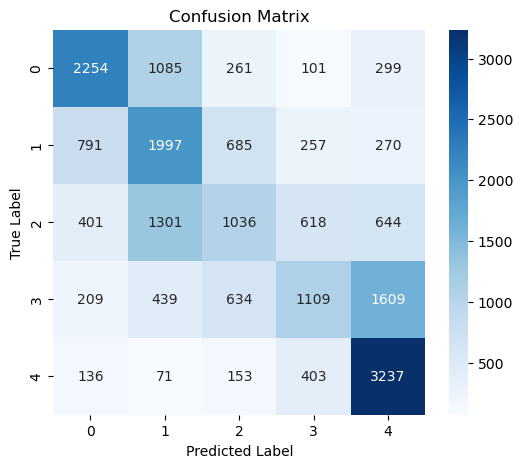

In [56]:
import seaborn as sns
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [57]:
test5_model.save('tricia_text_model_5.keras')

### Model 3

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Build the LSTM model
test8_model = Sequential()
test8_model.add(keras.Input(shape=(maxlen,)))
test8_model.add(Embedding(10000, 32))
test8_model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
test8_model.add(Dropout(0.5))  # Helps prevent overfitting
test8_model.add(Dense(5, activation='softmax'))
test8_model.summary()

# Train the Model
test8_model.compile(optimizer = RMSprop(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']) 

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)             │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,485 (1.25 MB)

 Trainable params: 328,485 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
from tensorflow.keras.optimizers import RMSprop
test8_model.compile(optimizer = RMSprop(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']) 

history_test8 = test8_model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 98s 46ms/step - acc: 0.3222 - loss: 1.4992 - val_acc: 0.4446 - val_loss: 1.2817
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - acc: 0.4350 - loss: 1.3004 - val_acc: 0.4624 - val_loss: 1.2382
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 98s 49ms/step - acc: 0.4520 - loss: 1.2631 - val_acc: 0.4701 - val_loss: 1.2187
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 88s 44ms/step - acc: 0.4680 - loss: 1.2384 - val_acc: 0.4730 - val_loss: 1.2125
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - acc: 0.4764 - loss: 1.2312 - val_acc: 0.4774 - val_loss: 1.2088
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 105s 53ms/step - acc: 0.4734 - loss: 1.2233 - val_acc: 0.4747 - val_loss: 1.2045
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - acc: 0.4829 - loss: 1.2152 - val_acc: 0.4773 - val_loss: 1.2051
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 102s 51ms/step - acc: 0.4862 - loss: 1.2105 - val_acc: 0.4794 - val_loss: 1.2024
Epoch 9/20
2000/2000 ━

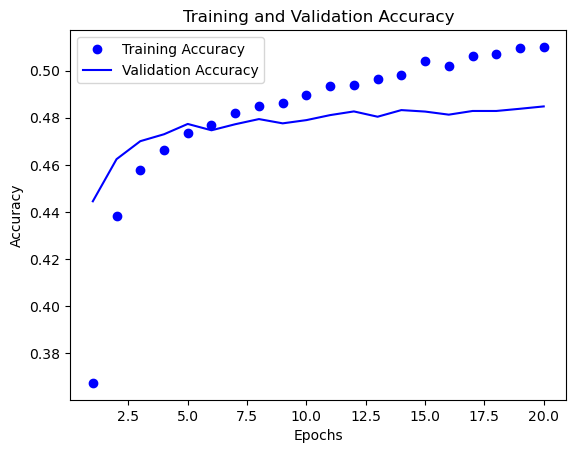

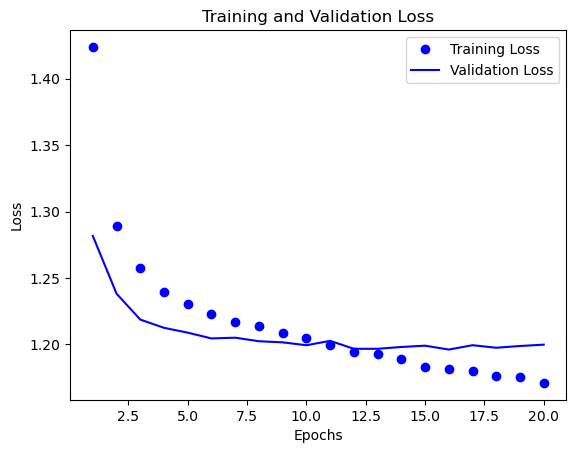

In [ ]:
acc = history_test8.history['acc']
val_acc = history_test8.history['val_acc']
loss = history_test8.history['loss']
val_loss = history_test8.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
val_acc = history_test8.history['val_acc']
max_val_acc = max(val_acc)
best_epoch = val_acc.index(max_val_acc) + 1 
print(f"Highest validation accuracy: {max_val_acc:.4f} at epoch {best_epoch}")

Highest validation accuracy: 0.4848 at epoch 20


In [ ]:
# Get model predictions
y_pred_probs = test8_model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
Accuracy: 0.4862
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.59      4000
           1       0.43      0.44      0.43      4000
           2       0.39      0.25      0.31      4000
           3       0.45      0.29      0.35      4000
           4       0.53      0.81      0.64      4000

    accuracy                           0.49     20000
   macro avg       0.47      0.49      0.47     20000
weighted avg       0.47      0.49      0.47     20000



In [ ]:
test8_model.save('tricia_text_model_8.keras')

### Model 4

In [ ]:
# Build the hybrid model: Conv1D + LSTM
hybrid_model = Sequential()
hybrid_model.add(keras.Input(shape=(maxlen,)))
hybrid_model.add(Embedding(10000, 32))
hybrid_model.add(Conv1D(64, kernel_size=5, activation='relu'))  # Convolutional layer for local feature extraction
hybrid_model.add(MaxPooling1D(pool_size=2))  # Downsample the feature maps
hybrid_model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))  # LSTM layer to model temporal dependencies
hybrid_model.add(Dropout(0.5))  # Helps prevent overfitting
hybrid_model.add(Dense(5, activation='softmax'))  # Softmax for classification
hybrid_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 342,885 (1.31 MB)

 Trainable params: 342,885 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
hybrid_model.compile(optimizer = RMSprop(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']) 

history = hybrid_model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 109s 47ms/step - acc: 0.3273 - loss: 1.4906 - val_acc: 0.4616 - val_loss: 1.2531
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - acc: 0.4496 - loss: 1.2734 - val_acc: 0.4715 - val_loss: 1.2209
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 77s 39ms/step - acc: 0.4741 - loss: 1.2334 - val_acc: 0.4756 - val_loss: 1.2081
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - acc: 0.4770 - loss: 1.2180 - val_acc: 0.4781 - val_loss: 1.2096
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - acc: 0.4915 - loss: 1.2026 - val_acc: 0.4786 - val_loss: 1.2029
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - acc: 0.4948 - loss: 1.1927 - val_acc: 0.4784 - val_loss: 1.2039
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 94s 47ms/step - acc: 0.4991 - loss: 1.1864 - val_acc: 0.4818 - val_loss: 1.2004
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 88s 44ms/step - acc: 0.5049 - loss: 1.1778 - val_acc: 0.4812 - val_loss: 1.2013
Epoch 9/15
2000/2000 ━━

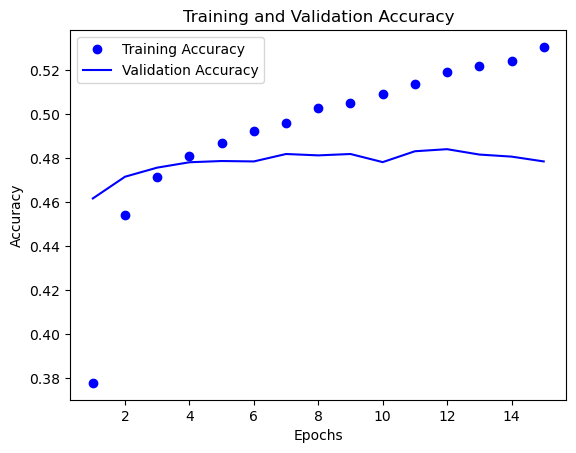

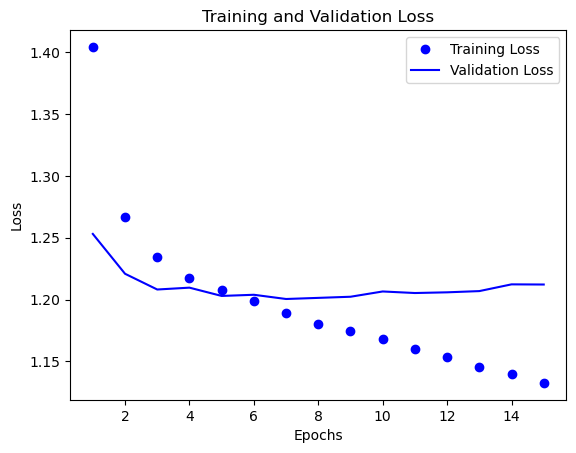

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
best_epoch = val_acc.index(max_val_acc) + 1 
print(f"Highest validation accuracy: {max_val_acc:.4f} at epoch {best_epoch}")

# Highest validation accuracy: 0.4886 at epoch 7

Highest validation accuracy: 0.4840 at epoch 12


In [ ]:
# Get model predictions
y_pred_probs = hybrid_model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
# Accuracy: 0.4859
# Classification Report:
#               precision    recall  f1-score   support

#            0       0.60      0.58      0.59      3299
#            1       0.41      0.48      0.44      3550
#            2       0.39      0.30      0.34      3355
#            3       0.45      0.36      0.40      3027
#            4       0.57      0.77      0.66      2491

#     accuracy                           0.49     15722
#    macro avg       0.48      0.50      0.49     15722
# weighted avg       0.48      0.49      0.48     15722

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
Accuracy: 0.4818
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      4000
           1       0.42      0.44      0.43      4000
           2       0.37      0.29      0.33      4000
           3       0.44      0.28      0.34      4000
           4       0.53      0.80      0.64      4000

    accuracy                           0.48     20000
   macro avg       0.47      0.48      0.47     20000
weighted avg       0.47      0.48      0.47     20000



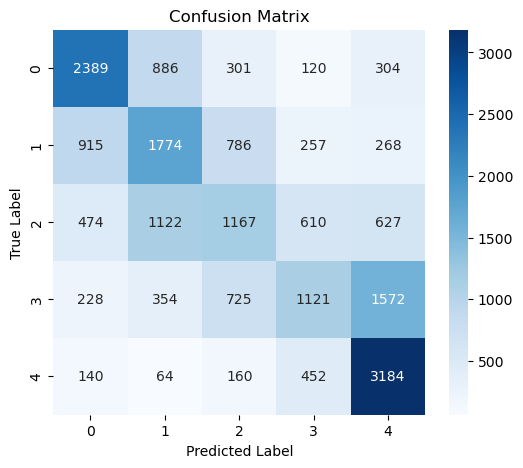

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
hybrid_model.save('tricia_text_model_11.keras')

### Model 5

In [ ]:
# Build the modified hybrid model: Conv1D + LSTM with adjusted dropout and learning rate
hybrid_model_2 = Sequential()
hybrid_model_2.add(keras.Input(shape=(maxlen,)))
hybrid_model_2.add(Embedding(10000, 16))
hybrid_model_2.add(Conv1D(64, kernel_size=5, activation='relu')) 
hybrid_model_2.add(MaxPooling1D(pool_size=2))  # Downsample the feature maps
hybrid_model_2.add(Conv1D(64, kernel_size=5, activation='relu'))  # Additional Conv1D layer
hybrid_model_2.add(MaxPooling1D(pool_size=2))  # Downsample again after the second Conv1D layer
hybrid_model_2.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
hybrid_model_2.add(Dropout(0.3)) 
hybrid_model_2.add(Dense(5, activation='softmax')) 
hybrid_model_2.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)             │ (None, 100, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 96, 64)              │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 44, 64)              │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,309 (774.64 KB)

 Trainable params: 198,309 (774.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
hybrid_model_2.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']) 

history = hybrid_model_2.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 79s 37ms/step - acc: 0.2701 - loss: 1.5706 - val_acc: 0.3532 - val_loss: 1.4552
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - acc: 0.3556 - loss: 1.4416 - val_acc: 0.4039 - val_loss: 1.3555
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - acc: 0.3951 - loss: 1.3628 - val_acc: 0.4217 - val_loss: 1.3175
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 63s 32ms/step - acc: 0.4155 - loss: 1.3257 - val_acc: 0.4415 - val_loss: 1.2878
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - acc: 0.4327 - loss: 1.3002 - val_acc: 0.4482 - val_loss: 1.2653
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - acc: 0.4434 - loss: 1.2776 - val_acc: 0.4551 - val_loss: 1.2491
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - acc: 0.4547 - loss: 1.2554 - val_acc: 0.4636 - val_loss: 1.2365
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - acc: 0.4642 - loss: 1.2441 - val_acc: 0.4676 - val_loss: 1.2301
Epoch 9/15
2000/2000 ━━━

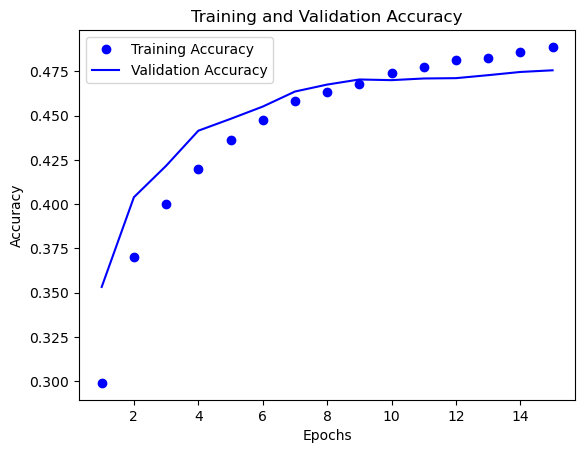

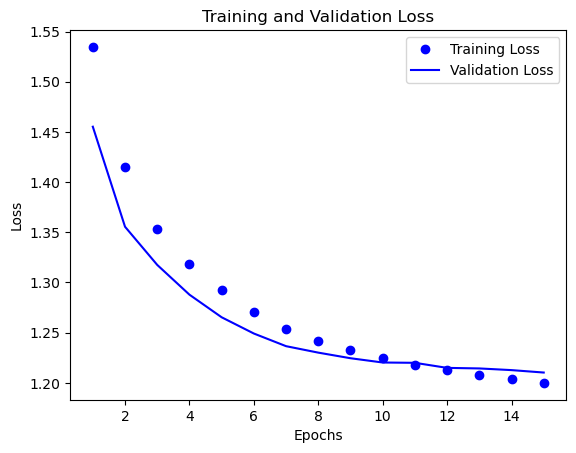

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
best_epoch = val_acc.index(max_val_acc) + 1 
print(f"Highest validation accuracy: {max_val_acc:.4f} at epoch {best_epoch}")

# Highest validation accuracy: 0.4881 at epoch 10

Highest validation accuracy: 0.4756 at epoch 15


In [ ]:
# Get model predictions
y_pred_probs = hybrid_model_2.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 492/492 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
# Accuracy: 0.4756
# Classification Report:
#               precision    recall  f1-score   support

#            0       0.63      0.54      0.58      3299
#            1       0.41      0.42      0.41      3550
#            2       0.36      0.40      0.38      3355
#            3       0.44      0.35      0.39      3027
#            4       0.57      0.73      0.64      2491

#     accuracy                           0.48     15722
#    macro avg       0.48      0.49      0.48     15722
# weighted avg       0.48      0.48      0.47     15722

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
Accuracy: 0.4761
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58      4000
           1       0.41      0.43      0.42      4000
           2       0.38      0.26      0.31      4000
           3       0.44      0.26      0.33      4000
           4       0.52      0.81      0.63      4000

    accuracy                           0.48     20000
   macro avg       0.46      0.48      0.46     20000
weighted avg       0.46      0.48      0.46     20000



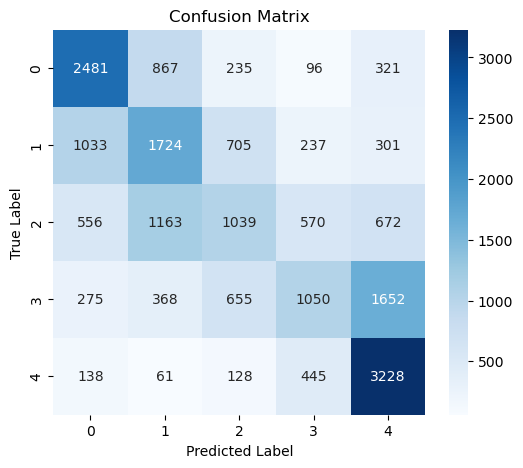

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
hybrid_model_2.save('tricia_text_model_12.keras')

### Model 6

In [81]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(10000, 16))
model.add(Conv1D(64, kernel_size=3, activation='relu'))  
model.add(MaxPooling1D(pool_size=2)) 
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, return_sequences = True)) 
model.add(Dropout(0.3))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3)) 
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))  
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=16,
                    validation_split=0.2)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 100, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 98, 64)              │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 49, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 49, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,037 (718.89 KB)

 Trainable params: 184,037 (718.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 264s 61ms/step - acc: 0.2550 - loss: 1.5827 - val_acc: 0.3235 - val_loss: 1.4912
Epoch 2/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 201s 50ms/step - acc: 0.3246 - loss: 1.4901 - val_acc: 0.3706 - val_loss: 1.4139
Epoch 3/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 196s 49ms/step - acc: 0.3645 - loss: 1.4159 - val_acc: 0.3957 - val_loss: 1.3561
Epoch 4/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 178s 45ms/step - acc: 0.3923 - loss: 1.3676 - val_acc: 0.4291 - val_loss: 1.3034
Epoch 5/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 217s 48ms/step - acc: 0.4096 - loss: 1.3310 - val_acc: 0.4384 - val_loss: 1.2828
Epoch 6/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 182s 45ms/step - acc: 0.4257 - loss: 1.3058 - val_acc: 0.4446 - val_loss: 1.2720
Epoch 7/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 182s 45ms/step - acc: 0.4374 - loss: 1.2897 - val_acc: 0.4493 - val_loss: 1.2622
Epoch 8/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 155s 39ms/step - acc: 0.4437 - loss: 1.2813 - val_acc: 0.4516 - val_loss: 1.2543
Epoch 9/15
4000/

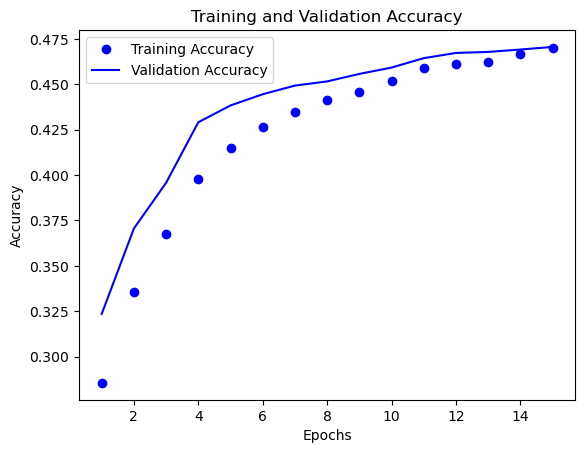

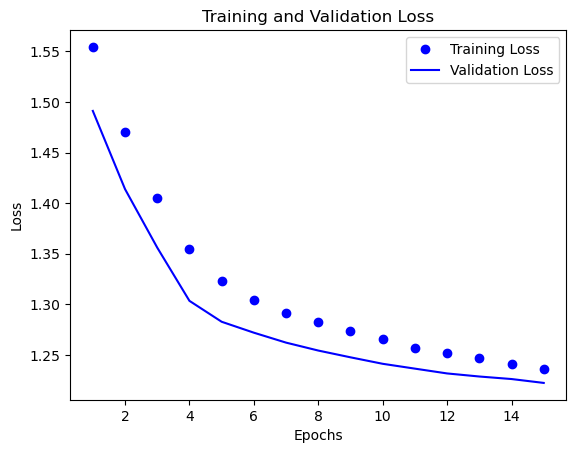

In [82]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
best_epoch = val_acc.index(max_val_acc) + 1 
print(f"Highest validation accuracy: {max_val_acc:.4f} at epoch {best_epoch}")

Highest validation accuracy: 0.4706 at epoch 15


In [84]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step
Accuracy: 0.4687
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.60      0.57      4000
           1       0.41      0.43      0.42      4000
           2       0.37      0.25      0.30      4000
           3       0.41      0.28      0.33      4000
           4       0.52      0.79      0.63      4000

    accuracy                           0.47     20000
   macro avg       0.45      0.47      0.45     20000
weighted avg       0.45      0.47      0.45     20000



In [148]:
model.save('tricia_text_model_14.keras')

## Step 3 – Evaluate the Model using Testing Data

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
X_test= pd.read_csv('./X_test_Tricia.csv')

In [7]:
y_test= pd.read_csv('./y_test_Tricia.csv')

In [8]:
# Model 1
model1 = keras.models.load_model("tricia_text_model_4.keras")
y_pred_probs1 = model1.predict(X_test)
y_pred1 = np.argmax(y_pred_probs1, axis=1)
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy for tricia_text_model_4: {accuracy1:.4f}")

# Model 2
model2 = keras.models.load_model("tricia_text_model_5.keras")
y_pred_probs2 = model2.predict(X_test)
y_pred2 = np.argmax(y_pred_probs2, axis=1)
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy for tricia_text_model_5: {accuracy2:.4f}")

# Model 3
model3 = keras.models.load_model("tricia_text_model_8.keras")
y_pred_probs3 = model3.predict(X_test)
y_pred3 = np.argmax(y_pred_probs3, axis=1)
accuracy3 = accuracy_score(y_test, y_pred3)
print(f"Accuracy for tricia_text_model_8: {accuracy3:.4f}")

# Model 4
model4 = keras.models.load_model("tricia_text_model_11.keras")
y_pred_probs4 = model4.predict(X_test)
y_pred4 = np.argmax(y_pred_probs4, axis=1)
accuracy4 = accuracy_score(y_test, y_pred4)
print(f"Accuracy for tricia_text_model_11: {accuracy4:.4f}")

# Model 5
model5 = keras.models.load_model("tricia_text_model_12.keras")
y_pred_probs5 = model5.predict(X_test)
y_pred5 = np.argmax(y_pred_probs5, axis=1)
accuracy5 = accuracy_score(y_test, y_pred5)
print(f"Accuracy for tricia_text_model_12: {accuracy5:.4f}")

# Model 6
model6 = keras.models.load_model("tricia_text_model_14.keras")
y_pred_probs6 = model6.predict(X_test)
y_pred6 = np.argmax(y_pred_probs6, axis=1)
accuracy6 = accuracy_score(y_test, y_pred6)
print(f"Accuracy for tricia_text_model_14: {accuracy6:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step
Accuracy for tricia_text_model_4: 0.4813
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step
Accuracy for tricia_text_model_5: 0.4817
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
Accuracy for tricia_text_model_8: 0.4862
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step
Accuracy for tricia_text_model_11: 0.4818
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
Accuracy for tricia_text_model_12: 0.4761
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step
Accuracy for tricia_text_model_14: 0.4687


In [ ]:
# Save the Best Model
model5 = keras.models.load_model("tricia_text_model_12.keras") ## model 4 was the best performing model when tested again other datasets
model.save('text_model_best_individualfortricia.keras')

## Step 4 – Use the Best Model to make prediction (Group)